In [24]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import timm
import json
import random

from tqdm.notebook import tqdm
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision import transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
import torch

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import segmentation_models_pytorch as smp
%matplotlib inline

In [25]:
f = open("Y:\Python\Datasets\Burger menu\menu_mask.json", "r")
data = json.load(f)

In [26]:
data = data["_via_img_metadata"]

In [27]:
img_dir = "Y:\\Python\\Datasets\\Burger menu\\images"
mask_dir = "Y:\\Python\\Datasets\\Burger menu\\masks"

In [28]:
def make_square(x,y,h,w):
    points = [[x,y], [(x),(y+h)], [(x+w),(y+h)], [(x+w),(y)]]
    return points

In [31]:
for key, value in data.items():
    filename = value["filename"]
    
    img_path = f"{img_dir}\\{filename}"
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    h,w,_ = img.shape
    
    mask = np.zeros((h, w))
    
    regions = value["regions"]
    
    for region in regions:
        shape_attributes = region["shape_attributes"]
        x = shape_attributes["x"]    #если точек много, вместо х будет all_points_x
        y = shape_attributes["y"]
        width = shape_attributes["width"]
        height = shape_attributes["height"]
        print(region)
        
        
        contours = []
        
        contours.append(make_square(x,y,height,width))
        print(contours)
        contours = np.array(contours)
        print(contours)
        break
    break
#        cv2.drawContours(mask, contours, -1, 255, -1)
#    cv2.imwrite(f"{mask_dir}\\{filename}", mask)

{'shape_attributes': {'name': 'rect', 'x': 21, 'y': 59, 'width': 50, 'height': 43}, 'region_attributes': {'name': 'menu'}}
[[[21, 59], [21, 102], [71, 102], [71, 59]]]
[[[ 21  59]
  [ 21 102]
  [ 71 102]
  [ 71  59]]]


In [7]:
img_data = []
for filename in os.listdir(img_dir):
    img_data.append(os.path.join(img_dir, filename))
    

In [8]:
mask_data = []
for filename in os.listdir(mask_dir):
    mask_data.append(os.path.join(mask_dir, filename))

In [9]:
df = pd.DataFrame()

In [10]:
df["image"] = img_data
df["mask"] = mask_data

(1280, 719, 3)
(1280, 719)


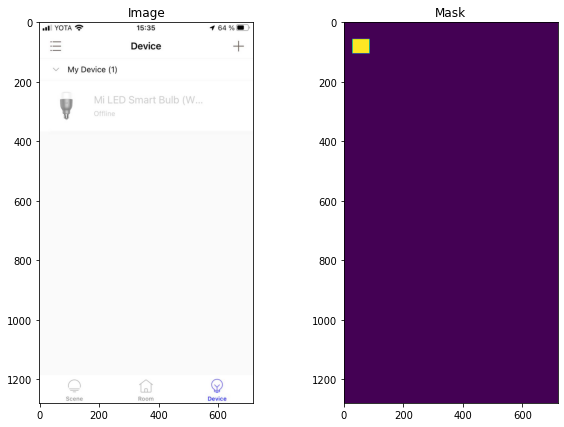

In [11]:
img_index = random.randint(0, len(df["image"])-1)
img1 = cv2.imread(df["image"][img_index])
img1_mask = cv2.imread(df["mask"][img_index], 0)
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1,2,1)
plt.imshow(img1)
plt.title("Image")
fig.add_subplot(1,2,2)
plt.imshow(img1_mask)
plt.title("Mask")
print(img1.shape)
print(img1_mask.shape)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
train_df, test_df = train_test_split(df, random_state = 1, shuffle = True)

In [14]:
def data_aug():
    augmented_data = A.Compose([
                        A.Resize(512,512),
                        A.Normalize(),
                        ToTensorV2()
    ])
    return augmented_data

In [15]:
class MenuDataset():
    def __init__(self, df, transform = None):
        super().__init__()
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image = cv2.imread(self.df.iloc[index, 0])
        mask = cv2.imread(self.df.iloc[index, 1])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        mask[mask>0.5] = 1.
        mask[mask<=0.5] = 0.
        augmented = self.transform(image=image, mask=mask)
        
        image = augmented["image"]
        mask = augmented["mask"].unsqueeze(0)
        
        return image.float(), mask.float()
    

In [16]:
train_dataset = MenuDataset(df, data_aug())
train_loader = DataLoader(train_dataset, batch_size = 4, shuffle = True)

test_dataset = MenuDataset(df, data_aug())
test_loader = DataLoader(test_dataset, batch_size = 2)


In [17]:
for image, mask in train_loader:
    print(image.shape)
    print(mask.shape)
    print(torch.unique(mask))
    break

torch.Size([4, 3, 512, 512])
torch.Size([4, 1, 512, 512])
tensor([0., 1.])


In [18]:
model = smp.Unet(encoder_name = "resnet34",
                encoder_weights = "imagenet",
                classes = 1).to(device)

In [19]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target*inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0 
    return intersection/union

In [20]:
#Segmentation Loss
def dice_coef_loss(inputs, target):
    smooth = 1.0 
    intersection = 2.0 * (target*inputs).sum() + smooth
    union = target.sum() + inputs.sum() + smooth
    return 1 - (intersection/union)

def bce_dice_loss(inputs, target):
    dice_score = dice_coef_loss(inputs, target)
    bce_loss = nn.BCEWithLogitsLoss()
    bce_score = bce_loss(inputs, target)
    
    return bce_score + dice_score

In [21]:
def compute_iou(model, loader, threshold=0.3):
    valloss = 0
    
    with torch.no_grad():

        for i_step, (data, target) in enumerate(loader):
            
            data = data.to(device)
            target = target.to(device)
            
            outputs = model(data)

            out_cut = np.copy(outputs.data.cpu().detach())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            picloss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            valloss += picloss

    return valloss / i_step

In [22]:
train_loss = []
validation_loss = []

loss_history = []
train_history = []
val_history = []

NUM_EPOCHS = 50
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(NUM_EPOCHS):
    model.train()
    model.to(device)
    losses = []
    train_iou = []
    
    for i_step, (data, target) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        target = target.to(device)
        
        preds = model(data)
        out_cut = np.copy(preds.data.cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
        
        train_dice = dice_coef_metric(out_cut, target.data.cpu().numpy())
        
        loss = bce_dice_loss(preds, target)
        
        losses.append(loss.item())
        train_iou.append(train_dice)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    val_mean_iou = compute_iou(model, test_loader)
    
    loss_history.append(np.array(losses).mean())
    train_history.append(np.array(train_iou).mean())
    val_history.append(val_mean_iou)
    
    print("Epoch [%d]" % (epoch))
    print("Mean loss on train:", np.array(losses).mean(), 
              "\nMean DICE on train:", np.array(train_iou).mean(), 
              "\nMean DICE on validation:", val_mean_iou)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [0]
Mean loss on train: 1.7108954668045044 
Mean DICE on train: 0.019344780314409546 
Mean DICE on validation: 0.007327573401948167


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1]
Mean loss on train: 1.49482901096344 
Mean DICE on train: 0.004654339062427338 
Mean DICE on validation: 0.004330243693409159


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [2]
Mean loss on train: 1.4016244649887084 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.0010768126346015793


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [3]
Mean loss on train: 1.3293184757232666 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [4]
Mean loss on train: 1.2790396451950072 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [5]
Mean loss on train: 1.2384360551834106 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [6]
Mean loss on train: 1.2004509687423706 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [7]
Mean loss on train: 1.1684261322021485 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [8]
Mean loss on train: 1.1429704904556275 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [9]
Mean loss on train: 1.1195067167282104 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [10]
Mean loss on train: 1.1010206937789917 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [11]
Mean loss on train: 1.087177038192749 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [12]
Mean loss on train: 1.0753643035888671 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [13]
Mean loss on train: 1.0671143054962158 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [14]
Mean loss on train: 1.0598002910614013 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [15]
Mean loss on train: 1.0534756660461426 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [16]
Mean loss on train: 1.0484331607818604 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [17]
Mean loss on train: 1.0441030502319335 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [18]
Mean loss on train: 1.0411619901657105 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [19]
Mean loss on train: 1.038173747062683 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [20]
Mean loss on train: 1.0353449821472167 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [21]
Mean loss on train: 1.0325996637344361 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [22]
Mean loss on train: 1.0307083129882812 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [23]
Mean loss on train: 1.0288727283477783 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [24]
Mean loss on train: 1.0271846294403075 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [25]
Mean loss on train: 1.0255332708358764 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [26]
Mean loss on train: 1.024364709854126 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [27]
Mean loss on train: 1.0228307485580443 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [28]
Mean loss on train: 1.0221657037734986 
Mean DICE on train: 0.0 
Mean DICE on validation: 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
model.to(device)
model.eval()
for batch, (x,y) in enumerate(tqdm(test_loader)):
    x = x.to(device)
    with torch.no_grad():
        preds = torch.sigmoid(model(x))
        preds = (preds > 0.5).float()
        
        x_to_img = T.ToPILImage()(make_grid(x))
        y_to_img = T.ToPILImage()(make_grid(y))
        preds_to_img = T.ToPILImage()(make_grid(preds))
        
        fig = plt.figure(figsize = (10,8))
        fig.add_subplot(3,1,1)
        plt.imshow(x_to_img)
        plt.title("Image")
        
        fig.add_subplot(3,1,2)
        plt.imshow(y_to_img)
        plt.title("Mask")
        
        fig.add_subplot(3,1,3)
        plt.imshow(preds_to_img)
        plt.title("Prediction")

In [ ]:
for x,y in train_loader:
    x = T.ToPILImage()(make_grid(x))
    x = T.functional.invert(x)
    plt.imshow(x)
    break